In [86]:
# Importing the required packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
df_raw = pd.read_csv('sc_raw_data.csv')

In [88]:
# TEST
# df_raw = df_raw.head(3)

In [89]:
# Setting up df_final to work with so that we keep the raw df intact
df_final = df_raw
df_final.head(5)

,order_id,weight,travel_cost_plant1,travel_cost_plant2,return_cost_plant1,return_cost_plant2,production_time,unload_time,time_from_p1,time_from_p2,time_to_p1,time_to_p2,due_date
0,1,32,8,10,3,5,3,3,7,4,7,10,41
1,2,79,4,9,4,3,5,3,7,7,6,6,24
2,3,38,5,10,5,2,5,1,7,9,7,10,40
3,4,33,10,6,2,3,1,3,4,7,6,5,36
4,5,55,5,6,3,2,4,2,9,8,10,9,36


Next we will calculate the required dependent variables needed for our optimization problem.

In [90]:
df_final['si1'] = df_final['due_date'] - df_final['production_time'] - df_final['time_from_p1']
df_final['si2'] = df_final['due_date'] - df_final['production_time'] - df_final['time_from_p2']
df_final['li1'] = df_final['due_date'] - df_final['time_from_p1']
df_final['li2'] = df_final['due_date'] - df_final['time_from_p2']
df_final['fi1'] = df_final['due_date'] + df_final['unload_time'] + df_final['time_to_p1']
df_final['fi2'] = df_final['due_date'] + df_final['unload_time'] + df_final['time_to_p2']

In [91]:
df_final

,order_id,weight,travel_cost_plant1,travel_cost_plant2,return_cost_plant1,return_cost_plant2,production_time,unload_time,time_from_p1,time_from_p2,time_to_p1,time_to_p2,due_date,si1,si2,li1,li2,fi1,fi2
0,1,32,8,10,3,5,3,3,7,4,7,10,41,31,34,34,37,51,54
1,2,79,4,9,4,3,5,3,7,7,6,6,24,12,12,17,17,33,33
2,3,38,5,10,5,2,5,1,7,9,7,10,40,28,26,33,31,48,51
3,4,33,10,6,2,3,1,3,4,7,6,5,36,31,28,32,29,45,44
4,5,55,5,6,3,2,4,2,9,8,10,9,36,23,24,27,28,48,47
5,6,37,5,9,5,4,5,2,8,10,9,7,48,35,33,40,38,59,57
6,7,82,7,7,4,3,2,2,6,9,9,4,16,8,5,10,7,27,22
7,8,96,6,10,5,5,4,3,7,7,5,7,45,34,34,38,38,53,55
8,9,58,9,8,5,3,1,2,8,4,10,10,39,30,34,31,35,51,51
9,10,49,10,6,5,4,4,1,10,4,9,5,33,19,25,23,29,43,39


Now that we have set up the dataframe with due dates, we can extract the relevant data to set up our parameters.

In [92]:
# Set Up time
T = 70  # Example value, replace with actual number of time periods

In [149]:
# Define the number of orders, plants, and time periods
n = len(df_final)  # Example value, replace with actual number of orders
m = 2   # Example value, replace with actual number of plants
dik = [] # Example values for transportation costs from customer to plant
d0ik = []  # Example values for return transportation costs
li1 = [] # End of production for order i at plant 1
fi1 = [] # Vehicle returns to plant 1 after delivering order i
li2 = [] # End of production for order i at plant 2
fi2 = [] # Vehicle returns to plant 2 after delivering order i
wi = [] # Example values for profit weights for orders
for index, row in df_final.iterrows():
    forward_cost= [row['travel_cost_plant1'], row['travel_cost_plant2']]
    return_cost = [row['return_cost_plant1'], row['return_cost_plant2']]
    li1.append(row['li1'])
    li2.append(row['li2'])
    fi1.append(row['fi1'])
    fi2.append(row['fi2'])
    dik.append(forward_cost)
    d0ik.append(return_cost)
    wi.append(row['weight'])

# Parameters (these should be initialized with actual data)
vk = [1, 1]  # Example values for initial number of vehicles at each plant
Ck = [1, 1]  # Example values for production capacity of each plant
lik = li1+li2 # Example values for parameters associated with time of production end time in plant k (1,2)
fik = fi1+fi2 # Example values for parameters associated with time of vehicle return to a plant k (1,2)

We can now set up our mathematical model in gurobi for vehicle routing.

In [162]:
# Initialize model
model = gp.Model("Production_and_Delivery_Scheduling")

# Decision variables
x = model.addVars(n, m, vtype=GRB.BINARY, name="x")
z = model.addVars(n, m, vtype=GRB.BINARY, name="z")
y = model.addVars(T, m, vtype=GRB.INTEGER, name="y")

# Objective function
model.setObjective(
    gp.quicksum(wi[i] * x[i, k] for i in range(n) for k in range(m)) -
    gp.quicksum(dik[i][k] * x[i, k] for i in range(n) for k in range(m)) -
    gp.quicksum(d0ik[i][k] * z[i, k] for i in range(n) for k in range(m)),
    GRB.MAXIMIZE
)

# Constraints
# (1) An order can be processed in at most one plant
model.addConstrs((gp.quicksum(x[i, k] for k in range(m)) <= 1 for i in range(n)), "OrderProcessing")

# (2) After an order is served, the vehicle must return to a production plant
model.addConstrs((gp.quicksum(x[i, k] for k in range(m)) == gp.quicksum(z[i, k] for k in range(m)) for i in range(n)), "VehicleReturn")

# (3) Initial number of vehicles at each plant
model.addConstrs((y[0, k] == vk[k] for k in range(m)), "InitialVehicles")

# (4) Number of available vehicles at each plant in every instant t
model.addConstrs((
    y[t, k] == y[0, k] - gp.quicksum(x[i, k] for i in range(n) if lik[i] < t) + gp.quicksum(z[i, k] for i in range(n) if fik[i] <= t)
    for t in range(1,T) for k in range(m)), "AvailableVehicles")

# (5) An order i may be processed in plant k if there are available vehicles in instant lik
model.addConstrs((
    gp.quicksum(x[i, k] for i in range(n) if lik[i] == t) <= y[t, k]
    for t in range(1,T) for k in range(m)), "OrderProcessingAtPlant")

# (6) No more than Ck orders are assigned to any time period in any production plant
# model.addConstrs((
#     gp.quicksum(x[i, k] for i in range(n) if (lik[i] == t)) <= Ck[k]
#     for t in range(1,T) for k in range(m)), "ProductionCapacity")

# Optimize model
model.optimize()

# Print the solution
for v in model.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective Value: {model.objVal}')

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 23.5.0 23F79)

CPU model: Intel(R) Core(TM) i7-8557U CPU @ 1.70GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 298 rows, 180 columns and 1790 nonzeros
Model fingerprint: 0xda3ffed2
Variable types: 0 continuous, 180 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 273 rows and 142 columns
Presolve time: 0.00s
Presolved: 25 rows, 38 columns, 100 nonzeros
Variable types: 0 continuous, 38 integer (38 binary)
Found heuristic solution: objective 247.0000000

Root relaxation: objective 2.750000e+02, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0   

In [163]:
df_final[['order_id', 'weight', 'si1', 'si2','li1', 'li2', 'fi1', 'fi2' ,'due_date']]

,order_id,weight,si1,si2,li1,li2,fi1,fi2,due_date
0,1,32,31,34,34,37,51,54,41
1,2,79,12,12,17,17,33,33,24
2,3,38,28,26,33,31,48,51,40
3,4,33,31,28,32,29,45,44,36
4,5,55,23,24,27,28,48,47,36
5,6,37,35,33,40,38,59,57,48
6,7,82,8,5,10,7,27,22,16
7,8,96,34,34,38,38,53,55,45
8,9,58,30,34,31,35,51,51,39
9,10,49,19,25,23,29,43,39,33


In [164]:
for o in range(n):    
    for p in range(m):
        # print(x[o,p])
        if x[o,p].x>0:
            print(f"Order {o+1} served by plant {p+1}")
        if z[o,p].x>0:
            print(f"Vehicle returns to plant {p+1} after serving order {o+1}")

Order 2 served by plant 1
Vehicle returns to plant 1 after serving order 2
Order 7 served by plant 2
Vehicle returns to plant 2 after serving order 7
Order 8 served by plant 1
Vehicle returns to plant 1 after serving order 8
Order 9 served by plant 2
Vehicle returns to plant 2 after serving order 9


In [168]:
p1 = []
p2 = []
time = []
for t in range(T):
    time.append(t)
    for p in range(m):
        if p == 0:
            p1.append(int(y[t,p].x))
        if p == 1:
            p2.append(int(y[t,p].x))
data = {
    'time':time,
    'plant_1':p1,
    'plant_2':p2
}
vehicle = pd.DataFrame(data)

In [169]:
vehicle.head(2)

,time,plant_1,plant_2
0,0,1,1
1,1,1,1


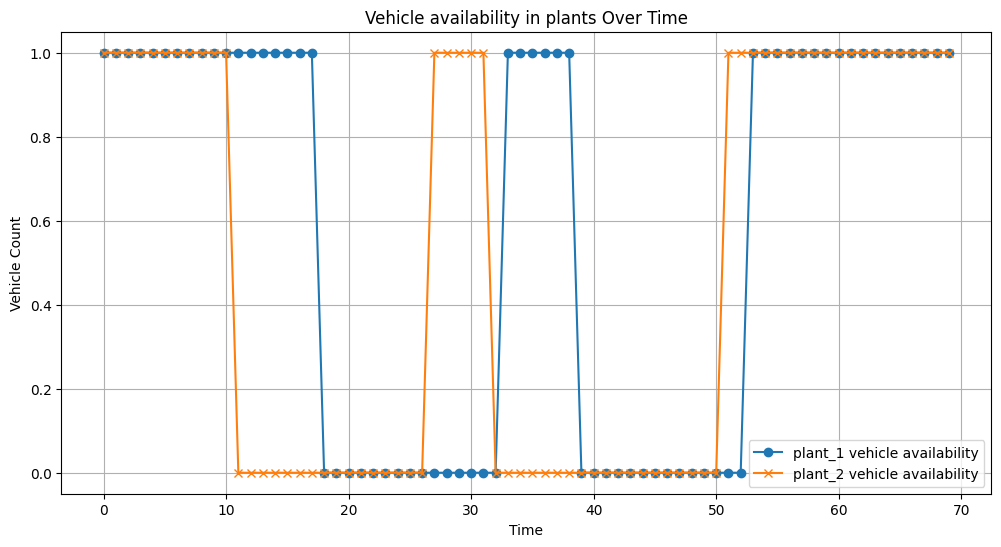

In [170]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(vehicle['time'], vehicle['plant_1'], label='plant_1 vehicle availability', marker='o')
plt.plot(vehicle['time'], vehicle['plant_2'], label='plant_2 vehicle availability', marker='x')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Vehicle Count')
plt.title('Vehicle availability in plants Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()